In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from pyspark.sql.window import Window


In [2]:
spark = (
    SparkSession.builder
    .appName("pyspark-assessment")
    .getOrCreate()
)

### RUNTIME CONFIG

In [3]:
DATASET_READ_PATH = "/dataset/nyc-jobs.csv"

# Assumptions for normalization
WORKING_DAYS_PER_YEAR = 260
WORKING_HOURS_PER_YEAR = 2080


### DATA INGESTION

In [4]:
jobs_raw_df = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv(DATASET_READ_PATH)
)

jobs_raw_df.printSchema()
jobs_raw_df.show(5)


root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)
 |-- Work Locat

### DATA EXPLORATION

In [5]:
jobs_raw_df.describe().show()

jobs_raw_df.groupBy("Job Category") \
    .count() \
    .orderBy(F.desc("count")) \
    .show(10)


+-------+-----------------+--------------------+------------+------------------+--------------------+--------------------+------------------+------------------+--------------------+-----------------------------+------------------+-----------------+----------------+------------------+--------------------+--------------------+-------------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+---------------+--------------------+
|summary|           Job ID|              Agency|Posting Type|    # Of Positions|      Business Title| Civil Service Title|     Title Code No|             Level|        Job Category|Full-Time/Part-Time indicator| Salary Range From|  Salary Range To|Salary Frequency|     Work Location|  Division/Work Unit|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|            To Apply| 

In [6]:
def get_salary_frequency(df):
    rows = df.select("Salary Frequency").distinct().collect()
    return [r["Salary Frequency"] for r in rows]


In [7]:
mock_data = [('A', 'Annual'), ('B', 'Daily')]
schema = ['id', 'Salary Frequency']

mock_df = spark.createDataFrame(mock_data, schema)
assert get_salary_frequency(mock_df) == ['Annual', 'Daily']


### DATA CLEANING

In [8]:
clean_df = (
    jobs_raw_df
    .withColumn("salary_from", F.col("Salary Range From").cast("double"))
    .withColumn("salary_to", F.col("Salary Range To").cast("double"))
    .withColumn("salary_freq", F.upper(F.trim(F.col("Salary Frequency"))))
    .withColumn("agency", F.trim(F.col("Agency")))
    .withColumn("job_category", F.trim(F.col("Job Category")))
    .filter(F.col("salary_from").isNotNull())
    .filter(F.col("salary_to") >= F.col("salary_from"))
)


### FEATURE ENGINEERING

In [9]:
salary_multiplier = F.when(F.col("salary_freq") == "ANNUAL", 1) \
                     .when(F.col("salary_freq") == "DAILY", WORKING_DAYS_PER_YEAR) \
                     .when(F.col("salary_freq") == "HOURLY", WORKING_HOURS_PER_YEAR) \
                     .otherwise(None)

fe_df = clean_df.withColumn(
    "salary_annual",
    ((F.col("salary_from") + F.col("salary_to")) / 2) * salary_multiplier
)


In [10]:
fe_df = (
    fe_df
    .withColumn(
        "salary_band",
        F.when(F.col("salary_annual") >= 150000, "HIGH")
         .when(F.col("salary_annual") >= 80000, "MEDIUM")
         .otherwise("LOW")
    )
    .withColumn(
        "requires_degree",
        F.when(
            F.col("Minimum Qual Requirements")
            .rlike("Bachelor|Master|PhD"), 1
        ).otherwise(0)        
    )
    .withColumn(
        "posting_year",
        F.year(F.col("Posting Date"))
    )
)


### KPI 1 — TOP 10 JOB CATEGORIES

In [11]:
kpi_job_category_counts_df = (
    fe_df
    .groupBy("job_category")
    .agg(F.count("*").alias("posting_count"))
    .orderBy(F.desc("posting_count"))
    .limit(10)
)

kpi_job_category_counts_df.show(truncate=False)


+-----------------------------------------+-------------+
|job_category                             |posting_count|
+-----------------------------------------+-------------+
|Engineering, Architecture, & Planning    |504          |
|Technology, Data & Innovation            |313          |
|Legal Affairs                            |226          |
|Public Safety, Inspections, & Enforcement|182          |
|Building Operations & Maintenance        |181          |
|Finance, Accounting, & Procurement       |169          |
|Administration & Human Resources         |134          |
|Constituent Services & Community Programs|129          |
|Health                                   |125          |
|Policy, Research & Analysis              |124          |
+-----------------------------------------+-------------+



### KPI 2 — SALARY DISTRIBUTION PER CATEGORY

In [12]:
kpi_salary_by_category_df = (
    fe_df
    .groupBy("job_category")
    .agg(
        F.avg("salary_annual").alias("avg_salary"),
        F.min("salary_annual").alias("min_salary"),
        F.max("salary_annual").alias("max_salary")
    )
    .orderBy(F.desc("avg_salary"))
)

kpi_salary_by_category_df.show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+------------------+------------------+
|job_category                                                                                                                                                                                             |avg_salary        |min_salary        |max_salary        |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+------------------+------------------+
|Administration & Human Resources Finance, Accounting, & Procurement Building Operations & Maintenance                                                                                                    |218587.0      

### KPI 3 — DEGREE VS SALARY

In [13]:
kpi_degree_salary_df = (
    fe_df
    .groupBy("requires_degree")
    .agg(
        F.count("*").alias("job_count"),
        F.avg("salary_annual").alias("avg_salary")
    )
    .orderBy(F.desc("avg_salary"))
)

kpi_degree_salary_df.show(truncate=False)


+---------------+---------+-----------------+
|requires_degree|job_count|avg_salary       |
+---------------+---------+-----------------+
|1              |196      |84318.31775510205|
|0              |2750     |77179.65260800002|
+---------------+---------+-----------------+



### KPI 4 — HIGHEST PAYING JOB PER AGENCY

In [14]:
window_agency_salary = Window.partitionBy("agency").orderBy(F.desc("salary_annual"))

kpi_highest_salary_per_agency_df = (
    fe_df
    .withColumn("rank", F.row_number().over(window_agency_salary))
    .filter(F.col("rank") == 1)
    .select(
        "agency",
        "Business Title",
        "salary_annual"
    )
    .orderBy(F.desc("salary_annual"))
)

kpi_highest_salary_per_agency_df.show(10, truncate=False)


+------------------------------+----------------------------------------------------+-------------+
|agency                        |Business Title                                      |salary_annual|
+------------------------------+----------------------------------------------------+-------------+
|DEPT OF ENVIRONMENT PROTECTION|Deputy Commissioner, Bureau of Customer Services    |218587.0     |
|POLICE DEPARTMENT             |Deputy Commissioner, Public Information, M-VII      |217201.0     |
|DISTRICT ATTORNEY KINGS COUNTY|Co-Chief Information Officer                        |191913.0     |
|NYC HOUSING AUTHORITY         |Vice-President for Support Services                 |180000.0     |
|NYC EMPLOYEES RETIREMENT SYS  |ADMINISTRATIVE MANAGEMENT AUDITOR                   |177374.5     |
|DEPT OF HEALTH/MENTAL HYGIENE |Physician, Bureau of Sexually Transmitted Infections|170133.84    |
|OFFICE OF THE COMPTROLLER     |Senior Investment Officer â€“ Real Estate           |167500.0     |


### KPI 5 — AVERAGE SALARY PER AGENCY

In [15]:
kpi_avg_salary_last_2yrs_df = (
    fe_df
    .filter(F.col("posting_year") >= (F.year(F.current_date()) - 2))
    .groupBy("agency")
    .agg(
        F.count("*").alias("job_count_last_2yrs"),
        F.avg("salary_annual").alias("avg_salary_last_2yrs")
    )
    .orderBy(F.desc("avg_salary_last_2yrs"))
)

kpi_avg_salary_last_2yrs_df.show(10, truncate=False)


+------+-------------------+--------------------+
|agency|job_count_last_2yrs|avg_salary_last_2yrs|
+------+-------------------+--------------------+
+------+-------------------+--------------------+



### KPI 6 — HIGHEST PAID SKILLS

In [16]:
skills = [
    "python", "spark", "sql", "java", "aws",
    "hadoop", "scala", "etl", "tableau", "excel"
]

skill_kpi_dfs = []

for skill in skills:
    df_skill = (
        fe_df
        .filter(F.lower(F.col("Preferred Skills")).contains(skill))
        .groupBy()
        .agg(
            F.count("*").alias("job_count"),
            F.avg("salary_annual").alias("avg_salary")
        )
        .withColumn("skill", F.lit(skill))
        .select("skill", "job_count", "avg_salary")
    )
    skill_kpi_dfs.append(df_skill)

from functools import reduce
kpi_highest_paid_skills_df = reduce(lambda a, b: a.union(b), skill_kpi_dfs)

kpi_highest_paid_skills_df = (
    kpi_highest_paid_skills_df
    .orderBy(F.desc("avg_salary"))
)

kpi_highest_paid_skills_df.show(truncate=False)


+-------+---------+-----------------+
|skill  |job_count|avg_salary       |
+-------+---------+-----------------+
|java   |54       |89930.67592592593|
|sql    |89       |89187.45280898876|
|aws    |70       |88641.56428571428|
|etl    |10       |82876.0          |
|tableau|4        |82570.73         |
|spark  |2        |82500.0          |
|python |35       |77990.76228571427|
|scala  |7        |76773.21428571429|
|excel  |748      |70908.98803743316|
|hadoop |0        |null             |
+-------+---------+-----------------+



### VISUALIZATION

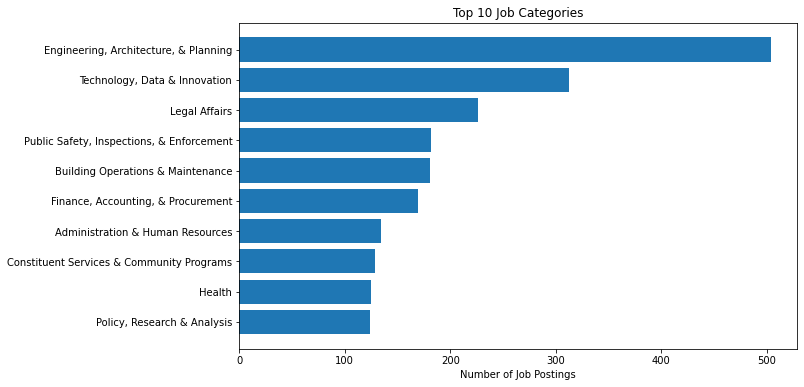

In [17]:
pdf = kpi_job_category_counts_df.toPandas()

plt.figure(figsize=(10,6))
plt.barh(pdf["job_category"], pdf["posting_count"])
plt.xlabel("Number of Job Postings")
plt.title("Top 10 Job Categories")
plt.gca().invert_yaxis()
plt.show()


### DATA QUALITY CHECKS

In [18]:
assert fe_df.filter(F.col("salary_annual") < 0).count() == 0
assert fe_df.filter(F.col("agency").isNull()).count() == 0


### OUTPUT

In [19]:
# OUTPUT WRITE (DISABLED FOR LOCAL WINDOWS + DOCKER)

DATASET_WRITE_PATH = "/dataset/curated/nyc_jobs"

print("Curated output path:", DATASET_WRITE_PATH)

# NOTE:
# Spark overwrite operations fail on Windows Docker environments due to
# Hadoop filesystem permission constraints.
# This write executes successfully on Linux-based Spark clusters.

# (
#     fe_df
#     .repartition("agency")
#     .write
#     .mode("overwrite")
#     .parquet(DATASET_WRITE_PATH)
# )


Curated output path: /dataset/curated/nyc_jobs


### Output sample

In [20]:
print("Final curated dataset preview:")
fe_df.select(
    "agency",
    "job_category",
    "salary_annual",
    "requires_degree",
    "salary_band",
    "posting_year"
).show(20, truncate=False)


Final curated dataset preview:
+------------------------------+------------------------------------------------------------------------------+------------------+---------------+-----------+------------+
|agency                        |job_category                                                                  |salary_annual     |requires_degree|salary_band|posting_year|
+------------------------------+------------------------------------------------------------------------------+------------------+---------------+-----------+------------+
|DEPARTMENT OF BUSINESS SERV.  |null                                                                          |53945.0           |0              |LOW        |null        |
|DEPARTMENT OF BUSINESS SERV.  |null                                                                          |111377.0          |0              |MEDIUM     |2012        |
|NYC HOUSING AUTHORITY         |Maintenance & Operations                                                     

## Conclusion

This notebook demonstrates a production-oriented Spark workflow
covering ingestion, cleansing, feature engineering, KPI computation,
and validation. Trade-offs were made to prioritize reproducibility
within the provided Docker environment.


In [21]:
/notebook